In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import DCCSMLM
import matplotlib.patches as patches



%matplotlib notebook

In [2]:
filename = "ExampleData/20180924_2.SciH5"

raw_data = DCCSMLM.DCCSMLM()
raw_data.load_channel(filename, channel="20180924_2b.locs", channel_id="mVenus")
raw_data.load_channel(filename, channel="20180924_2c.locs", channel_id="mCherry",
                      ca_file="ExampleData/CA_parameters.csv")


In [3]:
plt.subplot(221)
imgplot = plt.imshow(raw_data.channel["mVenus"].generate_reconstruction(), cmap="Greens", alpha=0.5, extent=[0,40960,0,40960])
imgplot = plt.imshow(raw_data.channel["mCherry"].generate_reconstruction(), cmap="Reds", alpha=0.5, extent=[0,40960,0,40960])



plt.subplot(222)
plt.hist(raw_data.channel["mVenus"].raw_data.intensity, color="green", alpha=0.5, bins=50)
plt.hist(raw_data.channel["mCherry"].raw_data.intensity, color="red", alpha=0.5, bins=50)
plt.axvline(100, color="black", ls=":")
plt.xlabel("Intensity (a.u.)")
plt.ylabel("Count")

plt.show()

<IPython.core.display.Javascript object>

In [4]:
# Find the fiducial markers based on an intensity_threshold
a = raw_data.channel["mVenus"].find_clusters(intensity_threshold=65) 
b = raw_data.channel["mCherry"].find_clusters(intensity_threshold=100) 

<IPython.core.display.Javascript object>


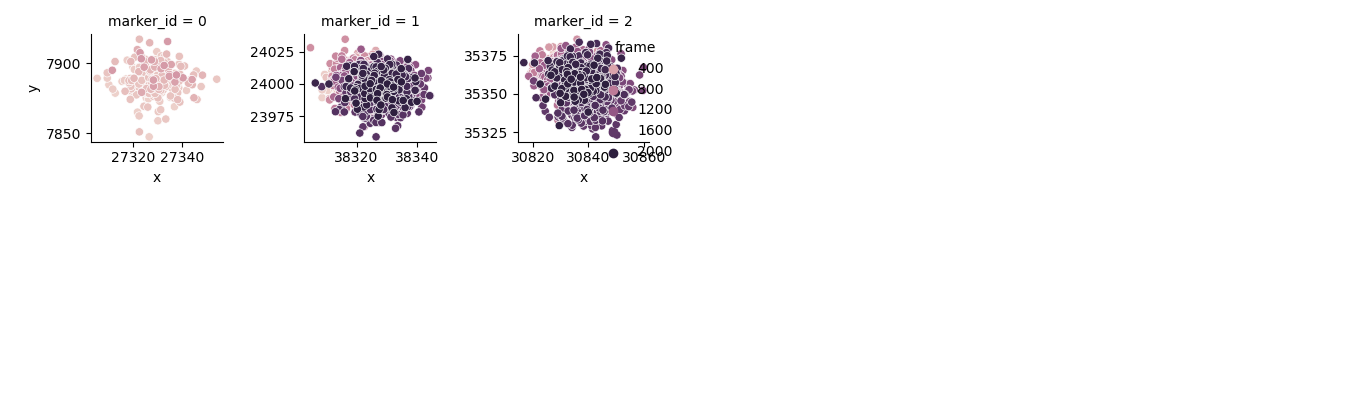

<IPython.core.display.Javascript object>


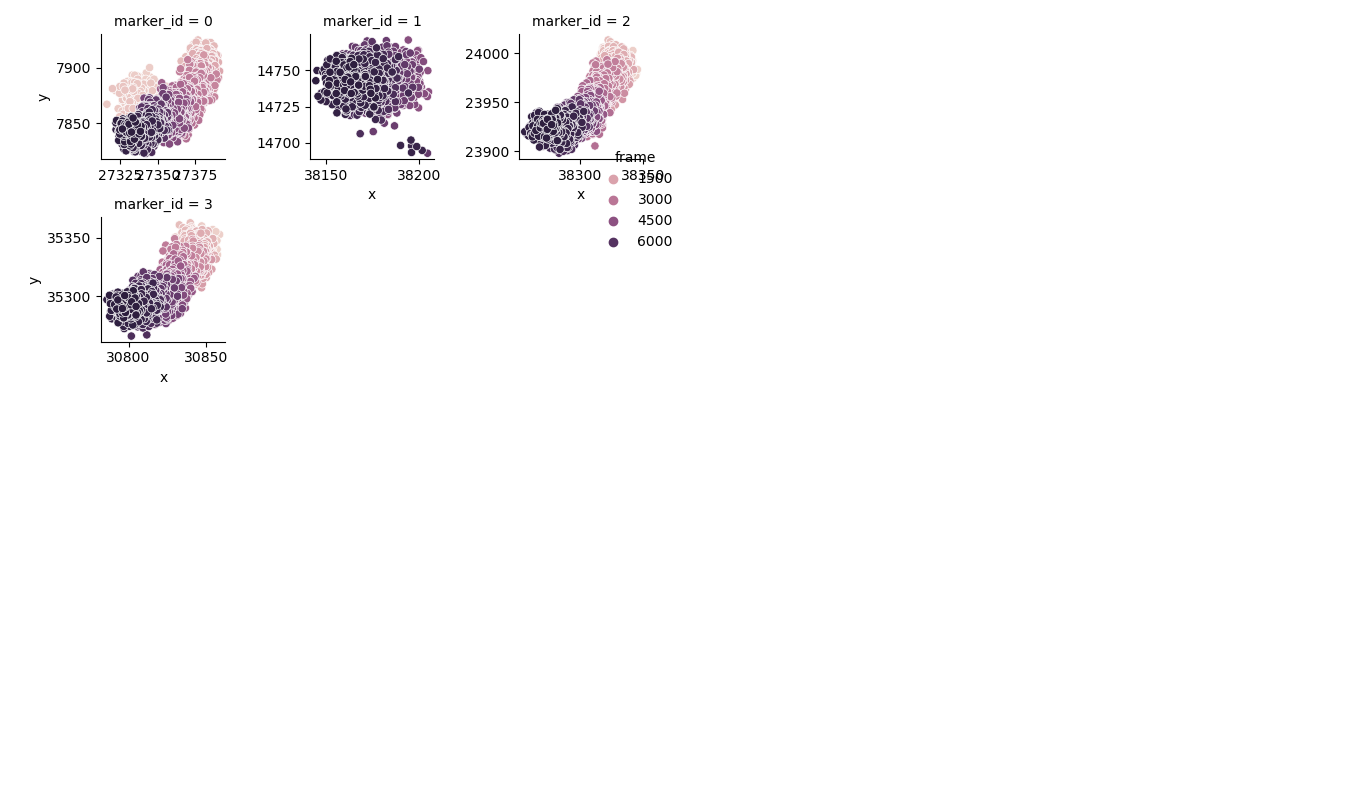

In [5]:
# Show the coordinates of all identified markers
sns.relplot(data=a, x="x", y="y", hue="frame", col="marker_id", col_wrap=3, height=2,
            facet_kws={'sharey': False, 'sharex': False})

sns.relplot(data=b, x="x", y="y", hue="frame", col="marker_id", col_wrap=3, height=2,
            facet_kws={'sharey': False, 'sharex': False})


<IPython.core.display.Javascript object>


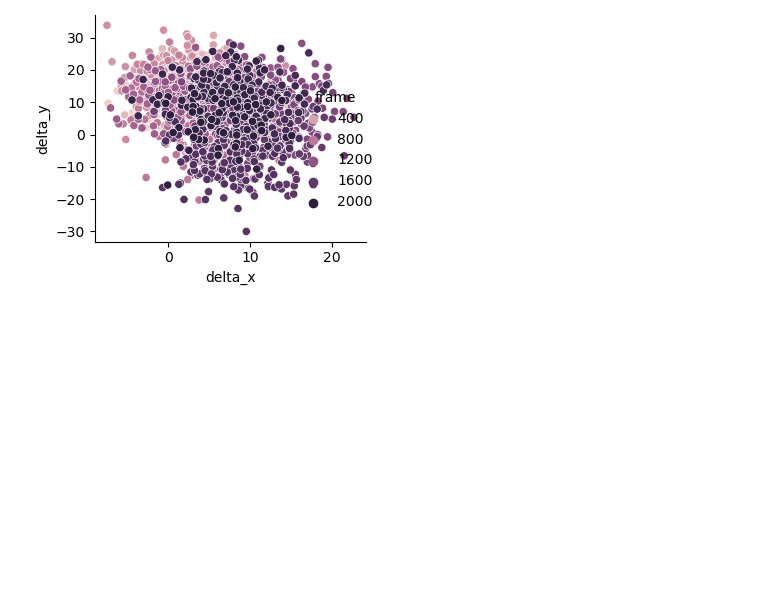

<IPython.core.display.Javascript object>


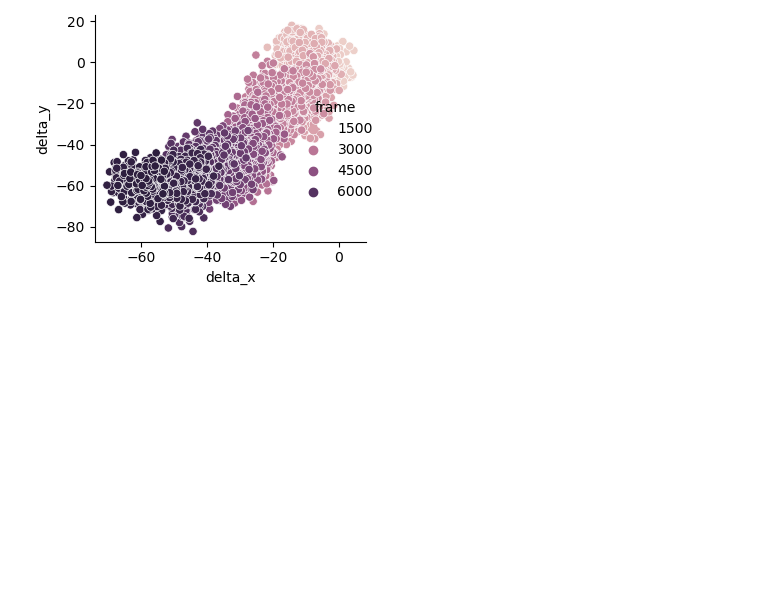

In [6]:
## Correct mVenus channel

ignore_marker = [0] # Ignore these marker IDs for drift correction

# Extract the trajectories for all IDs except for those in ignore_marker
id_list = list(a.marker_id.unique()[np.isin(a.marker_id.unique(), ignore_marker, invert=True)])

# Extract the trajectories, the mean is also saved in the drift variable of the channel
raw_data.channel["mVenus"].extract_drift(a, "marker_id", id_list=id_list)

# Plot the mean trajectory
g = sns.relplot(data = raw_data.channel["mVenus"].drift, x="delta_x", y="delta_y", kind="scatter", 
            hue="frame", height=3)
g.fig.suptitle("Mean drift over time in mVenus channel")
plt.show()



## Correct PAmCherry channel


ignore_marker = [0, 1] # Ignore these marker IDs for drift correction

# Extract the trajectories for all IDs except for those in ignore_marker
id_list = list(b.marker_id.unique()[np.isin(b.marker_id.unique(), ignore_marker, invert=True)])

# Extract the trajectories, the mean is also saved in the drift variable of the channel
raw_data.channel["mCherry"].extract_drift(b, "marker_id", id_list=id_list)

# Plot the mean trajectory
g = sns.relplot(data = raw_data.channel["mCherry"].drift, x="delta_x", y="delta_y", kind="scatter", 
            hue="frame", height=3)
g.fig.suptitle("Mean drift over time in PAmCherry channel")
plt.show()


In [ ]:
raw_data.channel["mVenus"].correct_drift()
raw_data.channel["mCherry"].correct_drift()

In [ ]:
for channel in raw_data.channel:
    # Find all protein clusters in the channels
    raw_data.channel[channel].find_clusters(intensity_threshold=0.1, min_samples=3, eps=100, save_column="clusters") 



In [ ]:
rois = [(20000, 10000, 20000, 30000)]

# Display drift corrected image
plt.figure()
imgplot = plt.imshow(raw_data.channel["mVenus"].generate_reconstruction(cluster_column="clusters"), cmap="Greens", alpha=0.5, 
                     extent=[0,40960,0,40960])
imgplot = plt.imshow(raw_data.channel["mCherry"].generate_reconstruction(cluster_column="clusters"), cmap="Reds", alpha=0.5, 
                     extent=[0,40960,0,40960])

# draw rois on top of the image
for roi in rois:
    rect = patches.Rectangle((roi[0], roi[1]), roi[2], roi[3], linewidth=1, edgecolor='r', facecolor='none')
    plt.gca().add_patch(rect)

plt.show()




In [ ]:
coloc_ratio = raw_data.get_colocalization_ratio("mVenus", "mCherry", "clusters", distance_cutoff=100, rois=rois)
print(f"The colocalization ratio within the ROIs is {round(coloc_ratio, 5)}")